Saved scaling coefficients to scaling_coefficients_T0_30.0.csv


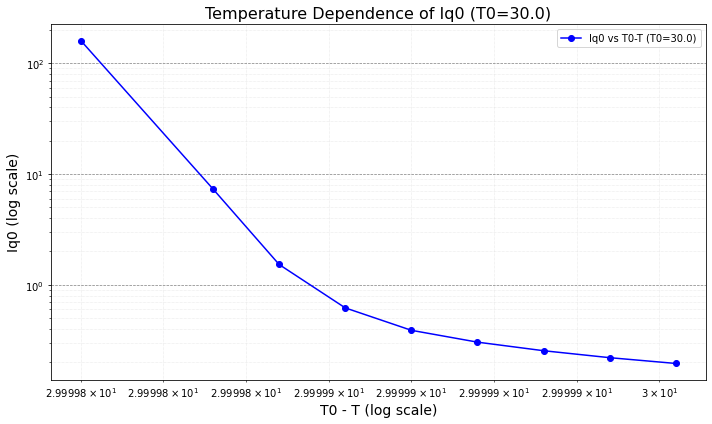

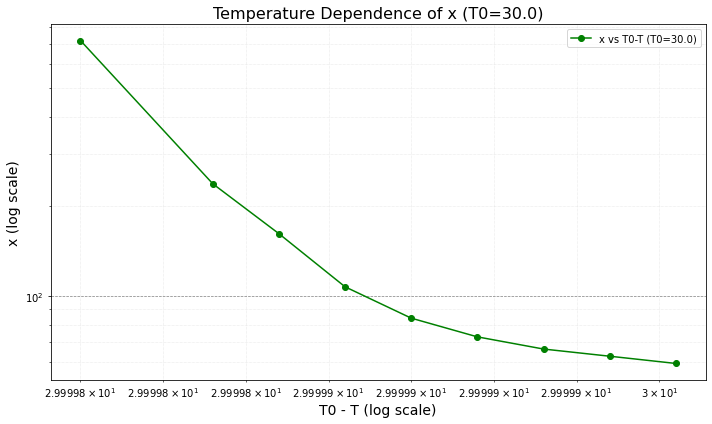

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import csv

# Load the data
with open('checkpoint.pickle', 'rb') as f:
    avg_ramp_up = pickle.load(f)
    avg_ramp_down = pickle.load(f)
    t_el = pickle.load(f)
    ql_sta = pickle.load(f)
    ql_dyn = pickle.load(f)

# Function to preprocess data and retain valid indices
def preprocess_data_with_indices(avg_data_list, ql_sta):
    """
    Preprocess the data to remove non-positive values from q and I.
    Returns cleaned q, avg_data_list, and the indices of valid curves.
    """
    cleaned_data_list = []
    cleaned_ql_sta = []
    valid_indices = []  # Track valid curve indices

    for idx, curve in enumerate(avg_data_list[:-1]):  # Exclude the last curve
        q = ql_sta
        i = curve['saxs_1d']
        
        # Filter to ensure both q and I are positive
        valid_indices_curve = (q > 0) & (i > 0)
        cleaned_q = q[valid_indices_curve]
        cleaned_i = i[valid_indices_curve]

        if len(cleaned_q) > 0 and len(cleaned_i) > 0:
            cleaned_ql_sta.append(cleaned_q)
            cleaned_data_list.append({'saxs_1d': cleaned_i})
            valid_indices.append(idx)  # Store index of valid curve

    return cleaned_data_list, cleaned_ql_sta, valid_indices

# Preprocess the data and get valid indices
avg_ramp_up_cleaned, ql_sta_cleaned, valid_indices = preprocess_data_with_indices(avg_ramp_up, ql_sta)

# Map valid indices to temperatures
temperatures = [t_el[i] for i in valid_indices]  # Correctly aligned temperatures

# Define the fitting function
def scattering_fit(q, Iq0, x):
    b = 1.7815  # Fixed value
    return Iq0 / (1 + (x * q)**b)

# Fit each temperature curve
fitted_parameters = []

for i, (q, data) in enumerate(zip(ql_sta_cleaned, avg_ramp_up_cleaned)):
    I = data['saxs_1d']

    # Fit the curve
    try:
        popt, pcov = curve_fit(scattering_fit, q, I, p0=[np.max(I), 1], bounds=([0, 0], [np.inf, np.inf]))
        Iq0_fit, x_fit = popt
        fitted_parameters.append((Iq0_fit, x_fit))
    except RuntimeError:
        pass

# Ensure temperatures and fitted parameters are aligned
if len(fitted_parameters) != len(temperatures):
    raise ValueError("Mismatch between fitted parameters and temperature list!")

# Explore different T0 values
T0_values = [30]  # CHANGE HHERE FOR MULTIPLE TEMPS

for T0 in T0_values:
    # Compute T0 - T
    T_diff = [T0 - T for T in temperatures]

    # Extract scaling coefficients
    Iq0_values = [param[0] for param in fitted_parameters]
    x_values = [param[1] for param in fitted_parameters]

    # Save data to a CSV file
    output_filename = f"scaling_coefficients_T0_{T0:.1f}.csv"
    with open(output_filename, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["T0 - T", "Iq0", "x", "T"])  # Header row
        for t_diff, iq0, x, temp in zip(T_diff, Iq0_values, x_values, temperatures):
            writer.writerow([t_diff, iq0, x, temp])
    print(f"Saved scaling coefficients to {output_filename}")

    # Plot Iq0 vs T0 - T
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.loglog(T_diff, Iq0_values, 'o-', color='blue', label=f'Iq0 vs T0-T (T0={T0:.1f})')
    ax.set_xlabel('T0 - T (log scale)', fontsize=14)
    ax.set_ylabel('Iq0 (log scale)', fontsize=14)
    ax.set_title(f'Temperature Dependence of Iq0 (T0={T0:.1f})', fontsize=16)
    ax.grid(which='major', linestyle='--', linewidth=0.7, color='gray')
    ax.grid(which='minor', linestyle=':', linewidth=0.5, color='lightgray')
    ax.legend()
    plt.tight_layout()
    plt.show()

    # Plot x vs T0 - T
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.loglog(T_diff, x_values, 'o-', color='green', label=f'x vs T0-T (T0={T0:.1f})')
    ax.set_xlabel('T0 - T (log scale)', fontsize=14)
    ax.set_ylabel('x (log scale)', fontsize=14)
    ax.set_title(f'Temperature Dependence of x (T0={T0:.1f})', fontsize=16)
    ax.grid(which='major', linestyle='--', linewidth=0.7, color='gray')
    ax.grid(which='minor', linestyle=':', linewidth=0.5, color='lightgray')
    ax.legend()
    plt.tight_layout()
    plt.show()
